# Production Simulation: Truncated KV Cache (Surrogate-Influenced Document Embeddings)

## Objective

This notebook tests a specific hypothesis about **surrogate-influenced KV caching**:

> Can we improve document embeddings by generating the KV cache with a surrogate query in context,
> then **discarding the surrogate tokens** and keeping only the document's KV cache?

## Key Difference from `production_simulation_experiment.ipynb`

| Aspect | Other Notebook (Full Context) | This Notebook (Truncated Cache) |
|--------|------------------------------|----------------------------------|
| Cache generation | Surrogate + Document | Surrogate + Document |
| Cache used at inference | **Full cache** (surrogate visible) | **Document only** (surrogate discarded) |
| What we're testing | Explicit query hints in context | Surrogate-influenced attention patterns |

## The Truncated Cache Hypothesis

When a transformer processes `[surrogate][document]`, the document tokens attend to the surrogate.
This may cause the document's KV representations to encode query-relevant information differently
than if processed in isolation.

By discarding the surrogate portion after cache generation, we test whether these
"surrogate-influenced" document embeddings alone (without the surrogate being visible)
improve answer quality.

```
┌─────────────────────────────────────────────────────────────────────────┐
│  CACHE GENERATION (surrogate present)                                  │
│                                                                         │
│    Input: [surrogate query] [document tokens...]                       │
│                    │              │                                     │
│                    │              └── Document attends to surrogate    │
│                    │                                                    │
│    KV Cache: [surr_kv...] [doc_kv_influenced_by_surr...]               │
│              ─────────── ────────────────────────────────              │
│               DISCARD              KEEP                                │
└─────────────────────────────────────────────────────────────────────────┘
                                    │
                                    ▼
┌─────────────────────────────────────────────────────────────────────────┐
│  INFERENCE (surrogate discarded)                                       │
│                                                                         │
│    Cached: [doc_kv_influenced_by_surr...]                              │
│    New:    [query tokens] [answer tokens]                              │
│                                                                         │
│    The query/answer can only attend to the document portion            │
└─────────────────────────────────────────────────────────────────────────┘
```

## Experimental Conditions

1. **Baseline**: KV cache from document only (no surrogate influence)
2. **Truncated Generated**: Document KV cache generated with surrogate context, then truncated
3. **Truncated Static**: Same, but with static surrogate queries

## Step 1: Setup

In [1]:
# Install dependencies
!pip install transformers torch datasets tqdm scipy bitsandbytes accelerate matplotlib sentence-transformers -q

In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
from tqdm.auto import tqdm
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import json
from collections import Counter
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

print("Imports complete.")

Imports complete.


In [7]:
@dataclass
class ExperimentConfig:
    """Configuration for the production simulation experiment."""
    
    # Model settings
    model_name: str = "mistralai/Mistral-7B-Instruct-v0.2"
    use_4bit: bool = True
    
    # Dataset settings
    dataset_name: str = "microsoft/ms_marco"
    dataset_config: str = "v1.1"
    dataset_split: str = "validation"
    num_samples: int = 2500
    min_passage_words: int = 50
    max_passage_words: int = 300
    
    # Surrogate generation
    surrogate_max_tokens: int = 45
    
    # Cache templates
    baseline_cache_template: str = "Document:\n{document}"
    surrogate_cache_template: str = (
        "This document may be relevant to queries like: {surrogate}\n\n"
        "Document:\n{document}"
    )
    query_template: str = "\n\nQuery: {query}\n\nAnswer:"
    
    # Embedding model
    embedding_model_name: str = "all-MiniLM-L6-v2"
    
    # Random seed
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


config = ExperimentConfig()
print(f"Device: {config.device}")
print(f"Model: {config.model_name}")

Device: cuda
Model: mistralai/Mistral-7B-Instruct-v0.2


In [8]:
# Set seeds and load models
torch.manual_seed(config.seed)
np.random.seed(config.seed)

print("Loading language model...")
if config.use_4bit:
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
    )
    model = AutoModelForCausalLM.from_pretrained(
        config.model_name,
        quantization_config=quantization_config,
        device_map="auto",
        trust_remote_code=True,
    )
else:
    model = AutoModelForCausalLM.from_pretrained(
        config.model_name,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True,
    )

tokenizer = AutoTokenizer.from_pretrained(config.model_name, trust_remote_code=True)
tokenizer.padding_side = "right"
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model.eval()
print(f"Language model loaded: {model.num_parameters():,} parameters")

print(f"\nLoading embedding model: {config.embedding_model_name}")
embed_model = SentenceTransformer(config.embedding_model_name)
print("Embedding model loaded.")

Loading language model...


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Language model loaded: 7,241,732,096 parameters

Loading embedding model: all-MiniLM-L6-v2


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedding model loaded.


## Step 2: Analyze MS MARCO to Identify Top Query Patterns

Before defining our 5 surrogate templates, let's analyze the actual query distribution in MS MARCO to make informed choices.

In [9]:
def analyze_query_patterns(dataset, num_queries: int = 5000) -> Dict:
    """
    Analyze query patterns in MS MARCO to identify top query types.
    """
    print(f"Analyzing {num_queries} queries...")
    
    # Collect queries
    queries = []
    for item in dataset:
        if item.get('query'):
            queries.append(item['query'].lower())
        if len(queries) >= num_queries:
            break
    
    # Analyze query starters (first word or first two words)
    first_words = Counter()
    first_two_words = Counter()
    
    # Query type patterns
    patterns = {
        'what_is': 0,        # "what is", "what are", "what does"
        'how_to': 0,         # "how to", "how do", "how does"
        'how_much': 0,       # "how much", "how many", "how long"
        'who_when_where': 0, # "who", "when", "where"
        'why': 0,            # "why"
        'define': 0,         # "define", "definition", "meaning"
        'cost_price': 0,     # "cost", "price", "salary", "pay"
        'average': 0,        # "average"
        'best': 0,           # "best"
        'can_does': 0,       # "can", "does", "is"
    }
    
    for query in queries:
        words = query.split()
        if words:
            first_words[words[0]] += 1
            if len(words) >= 2:
                first_two_words[f"{words[0]} {words[1]}"] += 1
        
        # Categorize by pattern
        if query.startswith(('what is', 'what are', 'what does', 'what do')):
            patterns['what_is'] += 1
        elif query.startswith(('how to', 'how do', 'how does')):
            patterns['how_to'] += 1
        elif query.startswith(('how much', 'how many', 'how long', 'how far')):
            patterns['how_much'] += 1
        elif query.startswith(('who ', 'when ', 'where ')):
            patterns['who_when_where'] += 1
        elif query.startswith('why'):
            patterns['why'] += 1
        elif any(w in query for w in ['define', 'definition', 'meaning of']):
            patterns['define'] += 1
        elif any(w in query for w in ['cost', 'price', 'salary', 'pay', 'earn']):
            patterns['cost_price'] += 1
        elif 'average' in query:
            patterns['average'] += 1
        elif query.startswith('best'):
            patterns['best'] += 1
        elif query.startswith(('can ', 'does ', 'is ', 'are ')):
            patterns['can_does'] += 1
    
    return {
        'total_queries': len(queries),
        'first_words': first_words.most_common(20),
        'first_two_words': first_two_words.most_common(20),
        'patterns': patterns,
        'sample_queries': queries[:20],
    }

In [10]:
# Load dataset and analyze
print("Loading MS MARCO dataset...")
full_dataset = load_dataset(
    config.dataset_name,
    config.dataset_config,
    split=config.dataset_split,
)
print(f"Dataset loaded: {len(full_dataset)} samples")

# Analyze query patterns
query_analysis = analyze_query_patterns(full_dataset, num_queries=5000)

print("\n" + "="*80)
print("MS MARCO QUERY PATTERN ANALYSIS")
print("="*80)

print(f"\nTotal queries analyzed: {query_analysis['total_queries']}")

print("\n--- Top 15 First Words ---")
for word, count in query_analysis['first_words'][:15]:
    pct = count / query_analysis['total_queries'] * 100
    print(f"  {word:<15} {count:>5} ({pct:.1f}%)")

print("\n--- Top 15 First Two Words ---")
for words, count in query_analysis['first_two_words'][:15]:
    pct = count / query_analysis['total_queries'] * 100
    print(f"  {words:<20} {count:>5} ({pct:.1f}%)")

print("\n--- Query Type Patterns ---")
sorted_patterns = sorted(query_analysis['patterns'].items(), key=lambda x: x[1], reverse=True)
for pattern, count in sorted_patterns:
    pct = count / query_analysis['total_queries'] * 100
    print(f"  {pattern:<20} {count:>5} ({pct:.1f}%)")

print("\n--- Sample Queries ---")
for q in query_analysis['sample_queries'][:10]:
    print(f"  - {q}")

Loading MS MARCO dataset...


README.md: 0.00B [00:00, ?B/s]

v1.1/validation-00000-of-00001.parquet:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

v1.1/train-00000-of-00001.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

v1.1/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10047 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/82326 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9650 [00:00<?, ? examples/s]

Dataset loaded: 10047 samples
Analyzing 5000 queries...

MS MARCO QUERY PATTERN ANALYSIS

Total queries analyzed: 5000

--- Top 15 First Words ---
  what             2041 (40.8%)
  how               794 (15.9%)
  where             197 (3.9%)
  average           165 (3.3%)
  is                140 (2.8%)
  cost               95 (1.9%)
  why                88 (1.8%)
  when               76 (1.5%)
  who                71 (1.4%)
  can                70 (1.4%)
  does               60 (1.2%)
  which              41 (0.8%)
  meaning            39 (0.8%)
  do                 35 (0.7%)
  are                30 (0.6%)

--- Top 15 First Two Words ---
  what is               1099 (22.0%)
  how much               230 (4.6%)
  how long               223 (4.5%)
  what does              216 (4.3%)
  what are               162 (3.2%)
  how to                 141 (2.8%)
  where is               107 (2.1%)
  cost of                 56 (1.1%)
  what kind               49 (1.0%)
  average cost            48 

## Step 3: Define the Top 5 Surrogate Query Templates

Based on the Doc2Query philosophy and real MS MARCO user behavior analysis, we define 5 surrogate generation templates designed to capture the **vocabulary mismatch** problem:

**The Core Insight**: Documents are written in formal, solution-oriented language, but users search with:
- Informal keywords and fragments
- Problem/symptom descriptions (not solution terms)
- Misconceptions and negative framings
- Messy, real-world language with typos and abbreviations

| # | Template Type | Purpose | Example |
|---|---------------|---------|---------|
| 1 | **Target Natural Language Question** | Ideal grammatically-correct question the doc answers | "What are the health benefits of green tea?" |
| 2 | **Keyword-ese Query** | How users actually type (keywords, no grammar) | "green tea benefits weight loss" |
| 3 | **Symptom/Scenario Query** | The *problem* the user has, not the solution | "feeling tired all the time natural remedies" |
| 4 | **Misconception/Negative Query** | What NOT to do, common myths | "is green tea bad for you caffeine" |
| 5 | **Messy Real-World Query** | Abbreviations, slang, typos, urgency | "best tea 4 energy need help asap" |

This approach ensures the document can be retrieved regardless of how the user phrases their query.

In [11]:
# Define the 5 surrogate generation templates
# These are designed based on Doc2Query philosophy and real MS MARCO user behavior

TOP_5_SURROGATE_TEMPLATES = {
    'target_question': {
        'name': 'Target Natural Language Question',
        'description': 'The ideal, grammatically-correct question this document perfectly answers',
        'prompt': (
            "You are helping index a document for search. Write the single most likely "
            "natural language question that a user would ask that this document perfectly answers. "
            "The question should be grammatically correct, clear, and specific. "
            "Output only the question (5-12 words), nothing else.\n\n"
            "Document:"
        ),
    },
    'keyword_query': {
        'name': 'Keyword-ese Query',
        'description': 'How users actually search: keyword strings without full sentences',
        'prompt': (
            "You are helping index a document for search. Write a search query the way "
            "real users type into Google: just keywords, no complete sentences, no question marks. "
            "Think of someone quickly typing a few relevant words. "
            "Output only the keyword query (3-6 words), nothing else.\n\n"
            "Document:"
        ),
    },
    'symptom_scenario': {
        'name': 'Symptom/Scenario Query',
        'description': 'The problem or symptom the user has, not the solution they need',
        'prompt': (
            "You are helping index a document for search. This document contains a solution or answer. "
            "Write a query that describes the PROBLEM or SYMPTOM that would lead someone to need this document. "
            "Focus on what the user is experiencing, not what they want to learn. "
            "For example, if the doc is about 'fixing a leaky faucet', the query might be 'water dripping from sink handle'. "
            "Output only the problem-focused query (4-10 words), nothing else.\n\n"
            "Document:"
        ),
    },
    'misconception_negative': {
        'name': 'Misconception/Negative Query',
        'description': 'Questions about what NOT to do, common myths, or concerns',
        'prompt': (
            "You are helping index a document for search. Write a query that reflects "
            "a common misconception, concern, or 'what NOT to do' question related to this topic. "
            "Think of someone who is worried, skeptical, or wants to avoid mistakes. "
            "Examples: 'is X bad for you', 'X side effects', 'mistakes to avoid with X', 'X myths'. "
            "Output only the concern/negative query (4-10 words), nothing else.\n\n"
            "Document:"
        ),
    },
    'messy_realworld': {
        'name': 'Messy Real-World Query',
        'description': 'Abbreviations, slang, typos, urgency - how people really search',
        'prompt': (
            "You are helping index a document for search. Write a messy, realistic search query "
            "like someone would actually type in a hurry: use common abbreviations (info, govt, diff, etc), "
            "internet slang, minor typos, or urgent language (help, asap, need, plz). "
            "Make it feel like a real person typing quickly on their phone. "
            "Output only the messy query (3-8 words), nothing else.\n\n"
            "Document:"
        ),
    },
}

print("Defined 5 Surrogate Templates (Doc2Query-inspired):")
print("="*70)
for key, template in TOP_5_SURROGATE_TEMPLATES.items():
    print(f"\n{key.upper()}")
    print(f"  Name: {template['name']}")
    print(f"  Purpose: {template['description']}")

Defined 5 Surrogate Templates (Doc2Query-inspired):

TARGET_QUESTION
  Name: Target Natural Language Question
  Purpose: The ideal, grammatically-correct question this document perfectly answers

KEYWORD_QUERY
  Name: Keyword-ese Query
  Purpose: How users actually search: keyword strings without full sentences

SYMPTOM_SCENARIO
  Name: Symptom/Scenario Query
  Purpose: The problem or symptom the user has, not the solution they need

MISCONCEPTION_NEGATIVE
  Name: Misconception/Negative Query
  Purpose: Questions about what NOT to do, common myths, or concerns

MESSY_REALWORLD
  Name: Messy Real-World Query
  Purpose: Abbreviations, slang, typos, urgency - how people really search


## Step 3b: Define 5 Static Surrogate Queries

In addition to document-specific generated surrogates, we test **static queries** that are the same for every document. This serves as a control to measure:

1. **How much value comes from document-specific generation** vs. generic intent priming
2. **Whether simple intent signals** are sufficient to improve cache quality

The static queries are designed to cover the main intent categories in MS MARCO:

| # | Static Query | Intent Coverage |
|---|--------------|-----------------|
| 1 | "What is this and what does it mean?" | Definitional (what is, define, meaning) |
| 2 | "How do I do this step by step?" | Procedural (how to, how do, instructions) |
| 3 | "How much does this cost or how long does it take?" | Quantitative (how much, how many, cost, time) |
| 4 | "What are the key facts I need to know?" | Factual (who, when, where, details) |
| 5 | "What problem does this solve?" | Problem/Solution (why, troubleshooting, help)

In [12]:
# Define 5 static surrogate queries (same for every document)
# These cover the main intent categories without being document-specific

STATIC_SURROGATE_QUERIES = {
    'static_definitional': {
        'name': 'Static: Definitional Intent',
        'query': 'What is this and what does it mean?',
        'covers': 'what is, define, meaning, explanation queries',
    },
    'static_procedural': {
        'name': 'Static: Procedural Intent', 
        'query': 'How do I do this step by step?',
        'covers': 'how to, how do, instructions, guide queries',
    },
    'static_quantitative': {
        'name': 'Static: Quantitative Intent',
        'query': 'How much does this cost or how long does it take?',
        'covers': 'how much, how many, cost, price, duration queries',
    },
    'static_factual': {
        'name': 'Static: Factual Intent',
        'query': 'What are the key facts I need to know?',
        'covers': 'who, when, where, what, factual detail queries',
    },
    'static_problem': {
        'name': 'Static: Problem/Solution Intent',
        'query': 'What problem does this solve?',
        'covers': 'why, troubleshooting, help, problem-solving queries',
    },
}

print("Defined 5 Static Surrogate Queries:")
print("="*70)
for key, info in STATIC_SURROGATE_QUERIES.items():
    print(f"\n{key.upper()}")
    print(f"  Query: \"{info['query']}\"")
    print(f"  Covers: {info['covers']}")

Defined 5 Static Surrogate Queries:

STATIC_DEFINITIONAL
  Query: "What is this and what does it mean?"
  Covers: what is, define, meaning, explanation queries

STATIC_PROCEDURAL
  Query: "How do I do this step by step?"
  Covers: how to, how do, instructions, guide queries

STATIC_QUANTITATIVE
  Query: "How much does this cost or how long does it take?"
  Covers: how much, how many, cost, price, duration queries

STATIC_FACTUAL
  Query: "What are the key facts I need to know?"
  Covers: who, when, where, what, factual detail queries

STATIC_PROBLEM
  Query: "What problem does this solve?"
  Covers: why, troubleshooting, help, problem-solving queries


## Step 4: Core Functions

In [13]:
def generate_surrogate_with_template(
    doc_text: str,
    template_prompt: str,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    config: ExperimentConfig
) -> str:
    """
    Generate a surrogate query using a specific template.
    """
    messages = [
        {
            "role": "user",
            "content": f"{template_prompt}\n\nText:\n{doc_text}"
        }
    ]
    
    prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    inputs = tokenizer(prompt, return_tensors="pt").to(config.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=config.surrogate_max_tokens,
            temperature=0.3,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    generated_tokens = outputs[0][inputs['input_ids'].shape[1]:]
    surrogate = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
    surrogate = surrogate.strip('"\'')
    surrogate = surrogate.split('\n')[0].strip()
    
    return surrogate


def generate_all_5_surrogates(
    doc_text: str,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    config: ExperimentConfig
) -> Dict[str, str]:
    """
    Generate all 5 surrogates for a document using the top 5 templates.
    """
    surrogates = {}
    for key, template in TOP_5_SURROGATE_TEMPLATES.items():
        surrogates[key] = generate_surrogate_with_template(
            doc_text, template['prompt'], model, tokenizer, config
        )
    return surrogates


def compute_similarity(text1: str, text2: str, embed_model: SentenceTransformer) -> float:
    """Compute semantic similarity between two texts."""
    embeddings = embed_model.encode([text1, text2])
    return float(cosine_similarity([embeddings[0]], [embeddings[1]])[0][0])

In [ ]:
from transformers import DynamicCache

def build_kv_cache(
    context: str,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    config: ExperimentConfig
) -> Tuple[int, any]:
    """
    Build a KV cache from the given context.
    Returns (context_length, past_key_values).
    """
    context_encoding = tokenizer(
        context, return_tensors="pt", add_special_tokens=True,
        padding=False, truncation=False
    )
    context_ids = context_encoding['input_ids'].to(config.device)
    
    with torch.no_grad():
        outputs = model(
            input_ids=context_ids,
            attention_mask=torch.ones_like(context_ids),
            use_cache=True,
            return_dict=True
        )
    
    return context_ids.shape[1], outputs.past_key_values


def extract_and_truncate_cache(past_key_values, keep_last_n: int) -> DynamicCache:
    """
    Extract tensors from cache, truncate to last N positions, return new DynamicCache.
    """
    # Get the original cache as legacy tuple format
    if hasattr(past_key_values, 'to_legacy_cache'):
        legacy_cache = past_key_values.to_legacy_cache()
    elif isinstance(past_key_values, (tuple, list)):
        legacy_cache = past_key_values
    else:
        # Try to convert by iterating
        legacy_cache = tuple(past_key_values)
    
    # Create new DynamicCache with truncated tensors
    new_cache = DynamicCache()
    
    for layer_idx, layer_kv in enumerate(legacy_cache):
        key, value = layer_kv[0], layer_kv[1]
        # Shape is (batch, num_heads, seq_len, head_dim)
        truncated_key = key[:, :, -keep_last_n:, :].contiguous()
        truncated_value = value[:, :, -keep_last_n:, :].contiguous()
        # Use update() to properly add to the cache
        new_cache.update(truncated_key, truncated_value, layer_idx)
    
    return new_cache


def build_truncated_kv_cache(
    surrogate: str,
    document: str,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    config: ExperimentConfig
) -> Tuple[int, DynamicCache]:
    """
    Build a KV cache with surrogate context, then TRUNCATE to keep only document portion.
    
    This implements the 'surrogate-influenced document embeddings' approach:
    1. Concatenate: [surrogate_prefix][document]
    2. Generate full KV cache (document attends to surrogate)
    3. Discard surrogate KV entries, keep only document's KV cache
    
    Returns (document_length, truncated_DynamicCache).
    """
    # Build the surrogate prefix and document text
    surrogate_prefix = f"This document may be relevant to queries like: {surrogate}\n\n"
    document_text = f"Document:\n{document}"
    
    # Tokenize document alone to get exact length (without special tokens)
    doc_encoding = tokenizer(
        document_text, return_tensors="pt", add_special_tokens=False,
        padding=False, truncation=False
    )
    doc_len = doc_encoding['input_ids'].shape[1]
    
    # Tokenize full context
    full_context = surrogate_prefix + document_text
    full_encoding = tokenizer(
        full_context, return_tensors="pt", add_special_tokens=True,
        padding=False, truncation=False
    )
    full_ids = full_encoding['input_ids'].to(config.device)
    
    # Generate full KV cache
    with torch.no_grad():
        outputs = model(
            input_ids=full_ids,
            attention_mask=torch.ones_like(full_ids),
            use_cache=True,
            return_dict=True
        )
    
    full_cache = outputs.past_key_values
    
    # Truncate: keep only the last doc_len positions (the document portion)
    truncated_cache = extract_and_truncate_cache(full_cache, doc_len)
    
    return doc_len, truncated_cache


def score_answer_with_cache(
    past_key_values: any,
    context_len: int,
    query_prompt: str,
    answer: str,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    config: ExperimentConfig
) -> float:
    """
    Score an answer using a pre-built KV cache.
    Returns mean NLL.
    """
    # Tokenize query
    query_encoding = tokenizer(
        query_prompt, return_tensors="pt", add_special_tokens=False,
        padding=False, truncation=False
    )
    query_ids = query_encoding['input_ids'].to(config.device)
    query_len = query_ids.shape[1]
    
    # Tokenize answer
    answer_encoding = tokenizer(
        answer, return_tensors="pt", add_special_tokens=False,
        padding=False, truncation=False
    )
    answer_ids = answer_encoding['input_ids'].to(config.device)
    answer_len = answer_ids.shape[1]
    
    # Extend cache with query
    combined_len = context_len + query_len
    attention_mask = torch.ones((1, combined_len), device=config.device)
    
    with torch.no_grad():
        query_outputs = model(
            input_ids=query_ids,
            attention_mask=attention_mask,
            past_key_values=past_key_values,
            use_cache=True,
            return_dict=True
        )
        extended_cache = query_outputs.past_key_values
    
    # Score answer
    combined_len_final = context_len + query_len + answer_len
    attention_mask_final = torch.ones((1, combined_len_final), device=config.device)
    
    with torch.no_grad():
        answer_outputs = model(
            input_ids=answer_ids,
            attention_mask=attention_mask_final,
            past_key_values=extended_cache,
            use_cache=False,
            return_dict=True
        )
    
    # Compute NLL
    logits = answer_outputs.logits
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = answer_ids[:, 1:].contiguous()
    shift_logits = shift_logits.view(-1, shift_logits.size(-1))
    shift_labels = shift_labels.view(-1)
    
    loss_fct = torch.nn.CrossEntropyLoss(reduction='sum')
    nll = loss_fct(shift_logits, shift_labels).item()
    
    num_scored = answer_len - 1
    return nll / num_scored if num_scored > 0 else 0.0

## Step 5: Load Evaluation Dataset

In [15]:
def count_words(text: str) -> int:
    return len(text.split())


def load_evaluation_samples(dataset, config: ExperimentConfig) -> List[Dict]:
    """
    Load samples for evaluation with passage, query, and answer.
    """
    print("Filtering samples with answers...")
    
    filtered_samples = []
    
    for item in tqdm(dataset, desc="Filtering"):
        passages = item.get('passages', {})
        passage_texts = passages.get('passage_text', [])
        is_selected = passages.get('is_selected', [])
        
        query = item.get('query', '')
        answers = item.get('answers', [])
        well_formed = item.get('wellFormedAnswers', [])
        
        if not passage_texts or not query:
            continue
        
        # Get best answer
        if well_formed and len(well_formed) > 0 and well_formed[0] != '[]':
            answer = well_formed[0]
        elif answers and len(answers) > 0 and answers[0] != 'No Answer Present.':
            answer = answers[0]
        else:
            continue
        
        # Find valid passage
        for i, passage in enumerate(passage_texts):
            word_count = count_words(passage)
            if config.min_passage_words <= word_count <= config.max_passage_words:
                if is_selected and i < len(is_selected) and is_selected[i] == 1:
                    filtered_samples.append({
                        'passage': passage,
                        'query': query,
                        'answer': answer
                    })
                    break
        
        if len(filtered_samples) >= config.num_samples * 2:
            break
    
    np.random.shuffle(filtered_samples)
    filtered_samples = filtered_samples[:config.num_samples]
    
    print(f"Selected {len(filtered_samples)} samples")
    return filtered_samples


# Load samples
samples = load_evaluation_samples(full_dataset, config)

print("\nSample preview:")
print(f"  Query: {samples[0]['query']}")
print(f"  Passage: {samples[0]['passage'][:150]}...")
print(f"  Answer: {samples[0]['answer']}")

Filtering samples with answers...


Filtering:   0%|          | 0/10047 [00:00<?, ?it/s]

Selected 2500 samples

Sample preview:
  Query: what temperature should it be to plant grass seeds
  Passage: Usually planted in the early fall, cool-season grass seeds prefer daytime temperatures ranging from 60 to 75 F. With this temperature range, the soil ...
  Answer: Between 50deg and 65deg F


## Step 6: Test Surrogate Generation

In [16]:
# Test surrogate generation on first sample
print("Testing surrogate generation with all 5 templates...")
print("="*80)

test_sample = samples[0]
print(f"\nDocument: {test_sample['passage'][:200]}...")
print(f"\nActual Query: {test_sample['query']}")

test_surrogates = generate_all_5_surrogates(
    test_sample['passage'], model, tokenizer, config
)

print("\nGenerated Surrogates:")
print("-"*60)
for key, surrogate in test_surrogates.items():
    similarity = compute_similarity(surrogate, test_sample['query'], embed_model)
    print(f"\n{TOP_5_SURROGATE_TEMPLATES[key]['name']}:")
    print(f"  Surrogate: {surrogate}")
    print(f"  Similarity to actual query: {similarity:.4f}")

# Find best match
best_key = max(test_surrogates.keys(), 
               key=lambda k: compute_similarity(test_surrogates[k], test_sample['query'], embed_model))
print(f"\nBest matching template: {best_key}")

Testing surrogate generation with all 5 templates...

Document: Usually planted in the early fall, cool-season grass seeds prefer daytime temperatures ranging from 60 to 75 F. With this temperature range, the soil itself is usually between 50 and 65 F -- the right...

Actual Query: what temperature should it be to plant grass seeds

Generated Surrogates:
------------------------------------------------------------

Target Natural Language Question:
  Surrogate: What is the ideal temperature range for planting cool-season grass seeds and why can warm-season grasses fail if planted during spring with cold temperatures?
  Similarity to actual query: 0.8349

Keyword-ese Query:
  Surrogate: cool-season grass seeds, fall planting, 60-75 F temperature, germination, right environment, grass seeds failure, warm-season grasses, spring planting, cold snap, weed seeds.
  Similarity to actual query: 0.6482

Symptom/Scenario Query:
  Surrogate: Grass seeds not germinating in cool soil (below 50°F)
 

## Step 7: Run the Main Experiment (Truncated Cache)

For each sample, we build:
1. **Baseline cache**: Document only (no surrogate influence)
2. **Truncated generated caches**: Build with surrogate+document, truncate to document only
3. **Truncated static caches**: Same approach with static surrogates

The key difference: surrogate tokens are **discarded** after cache generation.

In [ ]:
def evaluate_sample_with_truncated_cache(
    sample: Dict,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    embed_model: SentenceTransformer,
    config: ExperimentConfig
) -> Dict:
    """
    Evaluate a single sample using TRUNCATED KV caches.
    
    The surrogate is used during cache generation but DISCARDED afterward.
    Only the document's KV cache (influenced by attending to the surrogate) is kept.
    """
    passage = sample['passage']
    query = sample['query']
    answer = sample['answer']
    
    # ========== GENERATED SURROGATES (document-specific) ==========
    generated_surrogates = generate_all_5_surrogates(passage, model, tokenizer, config)
    
    # Compute similarities to actual query for generated surrogates
    generated_similarities = {
        key: compute_similarity(surrogate, query, embed_model)
        for key, surrogate in generated_surrogates.items()
    }
    
    # ========== STATIC SURROGATES (same for all documents) ==========
    static_surrogates = {key: info['query'] for key, info in STATIC_SURROGATE_QUERIES.items()}
    
    # Compute similarities to actual query for static surrogates
    static_similarities = {
        key: compute_similarity(surrogate, query, embed_model)
        for key, surrogate in static_surrogates.items()
    }
    
    # ========== BUILD CACHES ==========
    
    # Baseline cache (document only - no surrogate influence)
    baseline_context = config.baseline_cache_template.format(document=passage)
    baseline_len, baseline_cache = build_kv_cache(baseline_context, model, tokenizer, config)
    
    # TRUNCATED generated surrogate caches
    # Build with surrogate context, then discard surrogate portion
    generated_caches = {}
    generated_lens = {}
    for key, surrogate in generated_surrogates.items():
        cache_len, cache = build_truncated_kv_cache(
            surrogate, passage, model, tokenizer, config
        )
        generated_caches[key] = cache
        generated_lens[key] = cache_len
    
    # TRUNCATED static surrogate caches
    static_caches = {}
    static_lens = {}
    for key, surrogate in static_surrogates.items():
        cache_len, cache = build_truncated_kv_cache(
            surrogate, passage, model, tokenizer, config
        )
        static_caches[key] = cache
        static_lens[key] = cache_len
    
    # ========== SCORE ANSWERS ==========
    query_prompt = config.query_template.format(query=query)
    
    # Baseline
    baseline_nll = score_answer_with_cache(
        baseline_cache, baseline_len, query_prompt, answer,
        model, tokenizer, config
    )
    
    # Generated surrogate NLLs (using truncated caches)
    generated_nlls = {}
    for key in generated_surrogates.keys():
        nll = score_answer_with_cache(
            generated_caches[key], generated_lens[key], query_prompt, answer,
            model, tokenizer, config
        )
        generated_nlls[key] = nll
    
    # Static surrogate NLLs (using truncated caches)
    static_nlls = {}
    for key in static_surrogates.keys():
        nll = score_answer_with_cache(
            static_caches[key], static_lens[key], query_prompt, answer,
            model, tokenizer, config
        )
        static_nlls[key] = nll
    
    # ========== ROUTING DECISIONS ==========
    
    # Generated: route to highest-similarity surrogate
    gen_routed_key = max(generated_similarities.keys(), key=lambda k: generated_similarities[k])
    gen_routed_nll = generated_nlls[gen_routed_key]
    gen_routed_similarity = generated_similarities[gen_routed_key]
    
    # Generated: oracle (lowest NLL)
    gen_oracle_key = min(generated_nlls.keys(), key=lambda k: generated_nlls[k])
    gen_oracle_nll = generated_nlls[gen_oracle_key]
    
    # Static: route to highest-similarity surrogate
    static_routed_key = max(static_similarities.keys(), key=lambda k: static_similarities[k])
    static_routed_nll = static_nlls[static_routed_key]
    static_routed_similarity = static_similarities[static_routed_key]
    
    # Static: oracle (lowest NLL)
    static_oracle_key = min(static_nlls.keys(), key=lambda k: static_nlls[k])
    static_oracle_nll = static_nlls[static_oracle_key]
    
    return {
        'query': query,
        'answer_preview': answer[:50] + '...' if len(answer) > 50 else answer,
        
        # Generated surrogates
        'generated_surrogates': generated_surrogates,
        'generated_similarities': generated_similarities,
        'generated_nlls': generated_nlls,
        'gen_routed_key': gen_routed_key,
        'gen_routed_nll': gen_routed_nll,
        'gen_routed_similarity': gen_routed_similarity,
        'gen_oracle_key': gen_oracle_key,
        'gen_oracle_nll': gen_oracle_nll,
        
        # Static surrogates
        'static_surrogates': static_surrogates,
        'static_similarities': static_similarities,
        'static_nlls': static_nlls,
        'static_routed_key': static_routed_key,
        'static_routed_nll': static_routed_nll,
        'static_routed_similarity': static_routed_similarity,
        'static_oracle_key': static_oracle_key,
        'static_oracle_nll': static_oracle_nll,
        
        # Baseline
        'baseline_nll': baseline_nll,
        
        # Deltas (positive = surrogate better)
        'delta_gen_routed': baseline_nll - gen_routed_nll,
        'delta_gen_oracle': baseline_nll - gen_oracle_nll,
        'delta_static_routed': baseline_nll - static_routed_nll,
        'delta_static_oracle': baseline_nll - static_oracle_nll,
    }

In [ ]:
def run_truncated_cache_experiment(
    samples: List[Dict],
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    embed_model: SentenceTransformer,
    config: ExperimentConfig
) -> List[Dict]:
    """
    Run the truncated cache experiment on all samples.
    """
    results = []
    
    for i, sample in enumerate(tqdm(samples, desc="Evaluating samples")):
        try:
            result = evaluate_sample_with_truncated_cache(
                sample, model, tokenizer, embed_model, config
            )
            results.append(result)
            
            # Print progress every 100 samples
            if (i + 1) % 100 == 0:
                recent = results[-100:]
                avg_delta_gen = np.mean([r['delta_gen_routed'] for r in recent])
                avg_delta_static = np.mean([r['delta_static_routed'] for r in recent])
                print(f"  [{i+1}/{len(samples)}] Recent avg delta: Gen={avg_delta_gen:.3f}, Static={avg_delta_static:.3f}")
                
        except Exception as e:
            print(f"Error on sample {i}: {e}")
            continue
    
    return results

In [ ]:
# Run the truncated cache experiment
print(f"Running TRUNCATED CACHE experiment on {len(samples)} samples")
print(f"Comparing:")
print(f"  1. Baseline (document only, no surrogate influence)")
print(f"  2. Truncated Generated (surrogate-influenced doc cache, surrogate discarded)")
print(f"  3. Truncated Static (same with static surrogates)")
print("\nThis tests whether surrogate-influenced document embeddings improve quality")
print("even when the surrogate itself is not visible during inference.")
print("\nBuilding 11 caches per sample (1 baseline + 5 generated + 5 static)...")

results = run_truncated_cache_experiment(
    samples, model, tokenizer, embed_model, config
)

print(f"\nCompleted {len(results)} samples.")

## Step 8: Analyze Results

In [20]:
def analyze_experiment_results(results: List[Dict]) -> Dict:
    """
    Comprehensive analysis of experiment results for both generated and static surrogates.
    """
    baseline_nlls = np.array([r['baseline_nll'] for r in results])
    
    # Generated surrogates
    gen_routed_nlls = np.array([r['gen_routed_nll'] for r in results])
    gen_oracle_nlls = np.array([r['gen_oracle_nll'] for r in results])
    deltas_gen_routed = np.array([r['delta_gen_routed'] for r in results])
    deltas_gen_oracle = np.array([r['delta_gen_oracle'] for r in results])
    
    # Static surrogates
    static_routed_nlls = np.array([r['static_routed_nll'] for r in results])
    static_oracle_nlls = np.array([r['static_oracle_nll'] for r in results])
    deltas_static_routed = np.array([r['delta_static_routed'] for r in results])
    deltas_static_oracle = np.array([r['delta_static_oracle'] for r in results])
    
    # Per-template analysis for GENERATED
    gen_template_stats = {}
    for key in TOP_5_SURROGATE_TEMPLATES.keys():
        nlls = [r['generated_nlls'][key] for r in results]
        deltas = [r['baseline_nll'] - r['generated_nlls'][key] for r in results]
        times_routed = sum(1 for r in results if r['gen_routed_key'] == key)
        times_oracle = sum(1 for r in results if r['gen_oracle_key'] == key)
        
        gen_template_stats[key] = {
            'mean_nll': np.mean(nlls),
            'mean_delta': np.mean(deltas),
            'win_rate': np.mean([d > 0 for d in deltas]),
            'times_routed': times_routed,
            'times_oracle': times_oracle,
        }
    
    # Per-template analysis for STATIC
    static_template_stats = {}
    for key in STATIC_SURROGATE_QUERIES.keys():
        nlls = [r['static_nlls'][key] for r in results]
        deltas = [r['baseline_nll'] - r['static_nlls'][key] for r in results]
        times_routed = sum(1 for r in results if r['static_routed_key'] == key)
        times_oracle = sum(1 for r in results if r['static_oracle_key'] == key)
        
        static_template_stats[key] = {
            'mean_nll': np.mean(nlls),
            'mean_delta': np.mean(deltas),
            'win_rate': np.mean([d > 0 for d in deltas]),
            'times_routed': times_routed,
            'times_oracle': times_oracle,
        }
    
    # Statistical tests
    t_gen_routed, p_gen_routed = stats.ttest_rel(baseline_nlls, gen_routed_nlls)
    t_gen_oracle, p_gen_oracle = stats.ttest_rel(baseline_nlls, gen_oracle_nlls)
    t_static_routed, p_static_routed = stats.ttest_rel(baseline_nlls, static_routed_nlls)
    t_static_oracle, p_static_oracle = stats.ttest_rel(baseline_nlls, static_oracle_nlls)
    
    # Generated vs Static comparison
    t_gen_vs_static, p_gen_vs_static = stats.ttest_rel(gen_routed_nlls, static_routed_nlls)
    
    # Effect sizes
    def cohens_d(diff):
        return np.mean(diff) / np.std(diff, ddof=1) if np.std(diff) > 0 else 0
    
    return {
        'n_samples': len(results),
        
        # Baseline
        'mean_baseline_nll': np.mean(baseline_nlls),
        'std_baseline_nll': np.std(baseline_nlls),
        
        # Generated surrogates
        'mean_gen_routed_nll': np.mean(gen_routed_nlls),
        'std_gen_routed_nll': np.std(gen_routed_nlls),
        'mean_gen_oracle_nll': np.mean(gen_oracle_nlls),
        'std_gen_oracle_nll': np.std(gen_oracle_nlls),
        'win_rate_gen_routed': np.mean(deltas_gen_routed > 0),
        'win_rate_gen_oracle': np.mean(deltas_gen_oracle > 0),
        'mean_delta_gen_routed': np.mean(deltas_gen_routed),
        'mean_delta_gen_oracle': np.mean(deltas_gen_oracle),
        'median_delta_gen_routed': np.median(deltas_gen_routed),
        'cohens_d_gen_routed': cohens_d(deltas_gen_routed),
        't_stat_gen_routed': t_gen_routed,
        'p_value_gen_routed': p_gen_routed,
        't_stat_gen_oracle': t_gen_oracle,
        'p_value_gen_oracle': p_gen_oracle,
        'gen_template_stats': gen_template_stats,
        
        # Static surrogates
        'mean_static_routed_nll': np.mean(static_routed_nlls),
        'std_static_routed_nll': np.std(static_routed_nlls),
        'mean_static_oracle_nll': np.mean(static_oracle_nlls),
        'std_static_oracle_nll': np.std(static_oracle_nlls),
        'win_rate_static_routed': np.mean(deltas_static_routed > 0),
        'win_rate_static_oracle': np.mean(deltas_static_oracle > 0),
        'mean_delta_static_routed': np.mean(deltas_static_routed),
        'mean_delta_static_oracle': np.mean(deltas_static_oracle),
        'median_delta_static_routed': np.median(deltas_static_routed),
        'cohens_d_static_routed': cohens_d(deltas_static_routed),
        't_stat_static_routed': t_static_routed,
        'p_value_static_routed': p_static_routed,
        't_stat_static_oracle': t_static_oracle,
        'p_value_static_oracle': p_static_oracle,
        'static_template_stats': static_template_stats,
        
        # Generated vs Static comparison
        't_stat_gen_vs_static': t_gen_vs_static,
        'p_value_gen_vs_static': p_gen_vs_static,
        'gen_beats_static_rate': np.mean(gen_routed_nlls < static_routed_nlls),
    }

In [21]:
# Analyze results
analysis = analyze_experiment_results(results)

print("="*80)
print("PRODUCTION SIMULATION RESULTS")
print("="*80)
print(f"\nSamples analyzed: {analysis['n_samples']}")

print(f"\n{'='*80}")
print("ANSWER NLL BY CONDITION (lower = better)")
print(f"{'='*80}")
print(f"{'Condition':<30} {'Mean NLL':>12} {'Std':>10}")
print("-"*55)
print(f"{'Baseline (doc only)':<30} {analysis['mean_baseline_nll']:>12.4f} {analysis['std_baseline_nll']:>10.4f}")
print("-"*55)
print(f"{'Generated Routed':<30} {analysis['mean_gen_routed_nll']:>12.4f} {analysis['std_gen_routed_nll']:>10.4f}")
print(f"{'Generated Oracle':<30} {analysis['mean_gen_oracle_nll']:>12.4f} {analysis['std_gen_oracle_nll']:>10.4f}")
print("-"*55)
print(f"{'Static Routed':<30} {analysis['mean_static_routed_nll']:>12.4f} {analysis['std_static_routed_nll']:>10.4f}")
print(f"{'Static Oracle':<30} {analysis['mean_static_oracle_nll']:>12.4f} {analysis['std_static_oracle_nll']:>10.4f}")

print(f"\n{'='*80}")
print("WIN RATES vs BASELINE (positive delta = surrogate better)")
print(f"{'='*80}")
print(f"Generated Routed vs Baseline: {analysis['win_rate_gen_routed']*100:.1f}%")
print(f"Generated Oracle vs Baseline: {analysis['win_rate_gen_oracle']*100:.1f}%")
print(f"Static Routed vs Baseline:    {analysis['win_rate_static_routed']*100:.1f}%")
print(f"Static Oracle vs Baseline:    {analysis['win_rate_static_oracle']*100:.1f}%")

print(f"\n{'='*80}")
print("IMPROVEMENT OVER BASELINE (Delta = Baseline NLL - Surrogate NLL)")
print(f"{'='*80}")
print(f"{'Condition':<25} {'Mean Delta':>12} {'Median':>10} {'Cohens d':>10}")
print("-"*60)
print(f"{'Generated Routed':<25} {analysis['mean_delta_gen_routed']:>12.4f} {analysis['median_delta_gen_routed']:>10.4f} {analysis['cohens_d_gen_routed']:>10.4f}")
print(f"{'Generated Oracle':<25} {analysis['mean_delta_gen_oracle']:>12.4f} {'-':>10} {'-':>10}")
print(f"{'Static Routed':<25} {analysis['mean_delta_static_routed']:>12.4f} {analysis['median_delta_static_routed']:>10.4f} {analysis['cohens_d_static_routed']:>10.4f}")
print(f"{'Static Oracle':<25} {analysis['mean_delta_static_oracle']:>12.4f} {'-':>10} {'-':>10}")

print(f"\n{'='*80}")
print("STATISTICAL SIGNIFICANCE")
print(f"{'='*80}")
print("vs Baseline:")
print(f"  Generated Routed: t={analysis['t_stat_gen_routed']:.4f}, p={analysis['p_value_gen_routed']:.6f}")
print(f"  Static Routed:    t={analysis['t_stat_static_routed']:.4f}, p={analysis['p_value_static_routed']:.6f}")
print(f"\nGenerated vs Static:")
print(f"  t={analysis['t_stat_gen_vs_static']:.4f}, p={analysis['p_value_gen_vs_static']:.6f}")
print(f"  Generated beats Static: {analysis['gen_beats_static_rate']*100:.1f}% of samples")

print(f"\n{'='*80}")
print("PER-TEMPLATE ANALYSIS: GENERATED SURROGATES")
print(f"{'='*80}")
print(f"{'Template':<22} {'Win Rate':>10} {'Mean Delta':>12} {'Routed':>10} {'Oracle':>10}")
print("-"*70)
for key, s in sorted(analysis['gen_template_stats'].items(), 
                     key=lambda x: x[1]['mean_delta'], reverse=True):
    print(f"{key:<22} {s['win_rate']*100:>9.1f}% {s['mean_delta']:>12.4f} "
          f"{s['times_routed']:>10} {s['times_oracle']:>10}")

print(f"\n{'='*80}")
print("PER-TEMPLATE ANALYSIS: STATIC SURROGATES")
print(f"{'='*80}")
print(f"{'Template':<22} {'Win Rate':>10} {'Mean Delta':>12} {'Routed':>10} {'Oracle':>10}")
print("-"*70)
for key, s in sorted(analysis['static_template_stats'].items(), 
                     key=lambda x: x[1]['mean_delta'], reverse=True):
    short_key = key.replace('static_', '')
    print(f"{short_key:<22} {s['win_rate']*100:>9.1f}% {s['mean_delta']:>12.4f} "
          f"{s['times_routed']:>10} {s['times_oracle']:>10}")

PRODUCTION SIMULATION RESULTS

Samples analyzed: 2500

ANSWER NLL BY CONDITION (lower = better)
Condition                          Mean NLL        Std
-------------------------------------------------------
Baseline (doc only)                  1.4031     2.0160
-------------------------------------------------------
Generated Routed                     1.1682     1.6760
Generated Oracle                     0.9718     1.4670
-------------------------------------------------------
Static Routed                        1.2059     1.6949
Static Oracle                        1.0966     1.6052

WIN RATES vs BASELINE (positive delta = surrogate better)
Generated Routed vs Baseline: 69.2%
Generated Oracle vs Baseline: 84.4%
Static Routed vs Baseline:    66.7%
Static Oracle vs Baseline:    83.0%

IMPROVEMENT OVER BASELINE (Delta = Baseline NLL - Surrogate NLL)
Condition                   Mean Delta     Median   Cohens d
------------------------------------------------------------
Generated Route

In [22]:
# Conclusions
print("\n" + "="*80)
print("CONCLUSIONS")
print("="*80)

# Generated surrogates
print("\n--- GENERATED SURROGATES (document-specific) ---")
if analysis['p_value_gen_routed'] < 0.05:
    if analysis['mean_delta_gen_routed'] > 0:
        print("SIGNIFICANTLY IMPROVES over baseline")
        print(f"  - Win rate: {analysis['win_rate_gen_routed']*100:.1f}%")
        print(f"  - Mean improvement: {analysis['mean_delta_gen_routed']:.4f} NLL")
        print(f"  - Effect size: {analysis['cohens_d_gen_routed']:.4f}")
    else:
        print("Performs WORSE than baseline")
else:
    print("No significant difference from baseline")

# Static surrogates
print("\n--- STATIC SURROGATES (same for all documents) ---")
if analysis['p_value_static_routed'] < 0.05:
    if analysis['mean_delta_static_routed'] > 0:
        print("SIGNIFICANTLY IMPROVES over baseline")
        print(f"  - Win rate: {analysis['win_rate_static_routed']*100:.1f}%")
        print(f"  - Mean improvement: {analysis['mean_delta_static_routed']:.4f} NLL")
        print(f"  - Effect size: {analysis['cohens_d_static_routed']:.4f}")
    else:
        print("Performs WORSE than baseline")
else:
    print("No significant difference from baseline")

# Generated vs Static comparison
print("\n--- GENERATED vs STATIC COMPARISON ---")
if analysis['p_value_gen_vs_static'] < 0.05:
    if analysis['gen_beats_static_rate'] > 0.5:
        print(f"Generated SIGNIFICANTLY BETTER than Static")
        print(f"  - Generated beats Static: {analysis['gen_beats_static_rate']*100:.1f}% of samples")
        improvement = analysis['mean_delta_gen_routed'] - analysis['mean_delta_static_routed']
        print(f"  - Additional improvement from generation: {improvement:.4f} NLL")
    else:
        print(f"Static SIGNIFICANTLY BETTER than Generated")
        print(f"  - Static beats Generated: {(1-analysis['gen_beats_static_rate'])*100:.1f}% of samples")
else:
    print("No significant difference between Generated and Static")
    print(f"  - Generated beats Static: {analysis['gen_beats_static_rate']*100:.1f}% of samples")

# Oracle comparison
print("\n--- ORACLE UPPER BOUNDS ---")
print(f"Generated Oracle improvement: {analysis['mean_delta_gen_oracle']:.4f} NLL")
print(f"Static Oracle improvement:    {analysis['mean_delta_static_oracle']:.4f} NLL")

# Routing efficiency
gen_efficiency = (analysis['mean_delta_gen_routed'] / analysis['mean_delta_gen_oracle'] * 100 
                  if analysis['mean_delta_gen_oracle'] > 0 else 0)
static_efficiency = (analysis['mean_delta_static_routed'] / analysis['mean_delta_static_oracle'] * 100 
                     if analysis['mean_delta_static_oracle'] > 0 else 0)
print(f"\nRouting efficiency (how close to oracle):")
print(f"  Generated: {gen_efficiency:.1f}%")
print(f"  Static:    {static_efficiency:.1f}%")

# Key insight
print("\n" + "="*80)
print("KEY INSIGHT")
print("="*80)
gen_vs_static_delta = analysis['mean_delta_gen_routed'] - analysis['mean_delta_static_routed']
if gen_vs_static_delta > 0.01:
    print(f"\nDocument-specific generation provides {gen_vs_static_delta:.4f} additional NLL improvement.")
    print("The extra compute for generating surrogates IS worth it.")
elif gen_vs_static_delta < -0.01:
    print(f"\nStatic queries actually perform better by {-gen_vs_static_delta:.4f} NLL!")
    print("Simple intent priming may be sufficient - generation overhead may not be needed.")
else:
    print(f"\nGenerated and Static perform similarly (delta: {gen_vs_static_delta:.4f}).")
    print("Static queries may be a cost-effective alternative to generation.")


CONCLUSIONS

--- GENERATED SURROGATES (document-specific) ---
SIGNIFICANTLY IMPROVES over baseline
  - Win rate: 69.2%
  - Mean improvement: 0.2349 NLL
  - Effect size: 0.3907

--- STATIC SURROGATES (same for all documents) ---
SIGNIFICANTLY IMPROVES over baseline
  - Win rate: 66.7%
  - Mean improvement: 0.1972 NLL
  - Effect size: 0.3661

--- GENERATED vs STATIC COMPARISON ---
Generated SIGNIFICANTLY BETTER than Static
  - Generated beats Static: 54.1% of samples
  - Additional improvement from generation: 0.0377 NLL

--- ORACLE UPPER BOUNDS ---
Generated Oracle improvement: 0.4313 NLL
Static Oracle improvement:    0.3064 NLL

Routing efficiency (how close to oracle):
  Generated: 54.5%
  Static:    64.3%

KEY INSIGHT

Document-specific generation provides 0.0377 additional NLL improvement.
The extra compute for generating surrogates IS worth it.


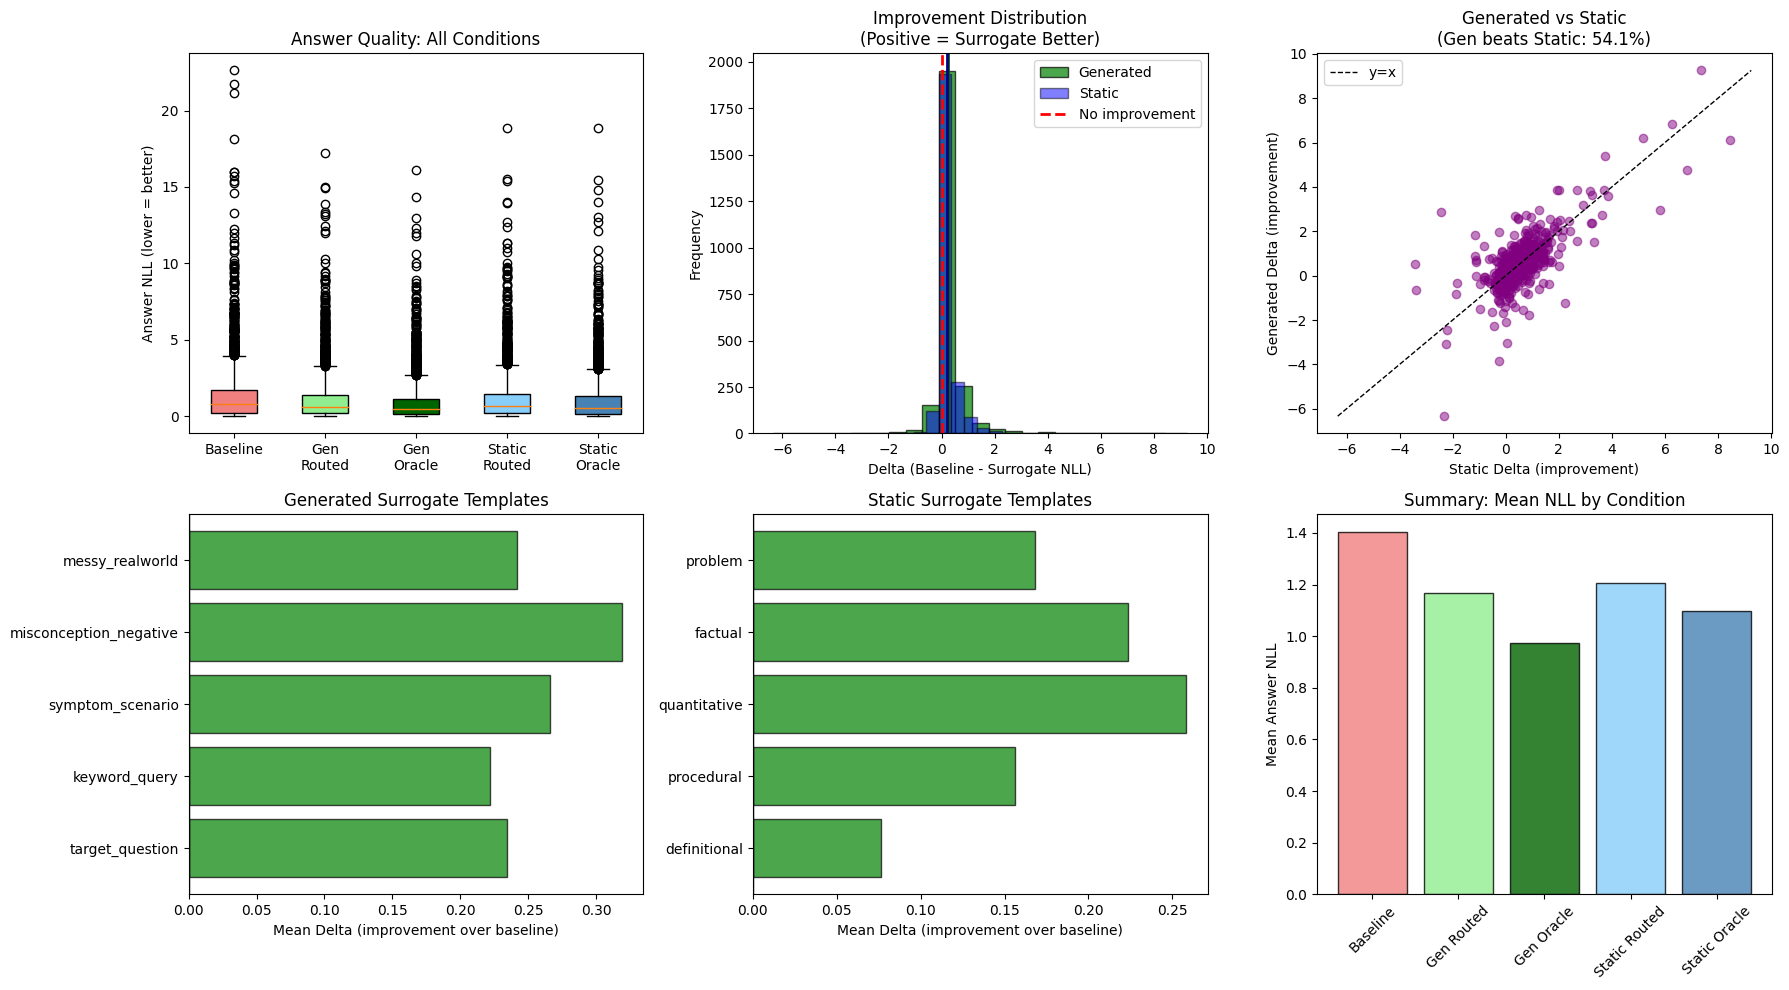


Figure saved to: production_simulation_results.png


In [23]:
# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Data extraction
baseline_nlls = [r['baseline_nll'] for r in results]
gen_routed_nlls = [r['gen_routed_nll'] for r in results]
gen_oracle_nlls = [r['gen_oracle_nll'] for r in results]
static_routed_nlls = [r['static_routed_nll'] for r in results]
static_oracle_nlls = [r['static_oracle_nll'] for r in results]

deltas_gen_routed = [r['delta_gen_routed'] for r in results]
deltas_static_routed = [r['delta_static_routed'] for r in results]

# Plot 1: Box plot comparison - all conditions
ax1 = axes[0, 0]
bp = ax1.boxplot([baseline_nlls, gen_routed_nlls, gen_oracle_nlls, 
                   static_routed_nlls, static_oracle_nlls],
                  labels=['Baseline', 'Gen\nRouted', 'Gen\nOracle', 
                          'Static\nRouted', 'Static\nOracle'],
                  patch_artist=True)
colors = ['lightcoral', 'lightgreen', 'darkgreen', 'lightskyblue', 'steelblue']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax1.set_ylabel('Answer NLL (lower = better)')
ax1.set_title('Answer Quality: All Conditions')

# Plot 2: Delta distribution - Generated vs Static
ax2 = axes[0, 1]
ax2.hist(deltas_gen_routed, bins=25, alpha=0.7, label='Generated', color='green', edgecolor='black')
ax2.hist(deltas_static_routed, bins=25, alpha=0.5, label='Static', color='blue', edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No improvement')
ax2.axvline(x=np.mean(deltas_gen_routed), color='darkgreen', linestyle='-', linewidth=2)
ax2.axvline(x=np.mean(deltas_static_routed), color='darkblue', linestyle='-', linewidth=2)
ax2.set_xlabel('Delta (Baseline - Surrogate NLL)')
ax2.set_ylabel('Frequency')
ax2.set_title('Improvement Distribution\n(Positive = Surrogate Better)')
ax2.legend()

# Plot 3: Generated vs Static scatter
ax3 = axes[0, 2]
ax3.scatter(deltas_static_routed, deltas_gen_routed, alpha=0.5, c='purple')
max_val = max(max(deltas_gen_routed), max(deltas_static_routed))
min_val = min(min(deltas_gen_routed), min(deltas_static_routed))
ax3.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1, label='y=x')
ax3.set_xlabel('Static Delta (improvement)')
ax3.set_ylabel('Generated Delta (improvement)')
ax3.set_title(f'Generated vs Static\n(Gen beats Static: {analysis["gen_beats_static_rate"]*100:.1f}%)')
ax3.legend()

# Plot 4: Per-template performance - Generated
ax4 = axes[1, 0]
gen_templates = list(analysis['gen_template_stats'].keys())
gen_deltas = [analysis['gen_template_stats'][t]['mean_delta'] for t in gen_templates]
colors = ['green' if d > 0 else 'red' for d in gen_deltas]
ax4.barh(gen_templates, gen_deltas, color=colors, alpha=0.7, edgecolor='black')
ax4.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax4.set_xlabel('Mean Delta (improvement over baseline)')
ax4.set_title('Generated Surrogate Templates')

# Plot 5: Per-template performance - Static
ax5 = axes[1, 1]
static_templates = [k.replace('static_', '') for k in analysis['static_template_stats'].keys()]
static_deltas = [analysis['static_template_stats'][k]['mean_delta'] 
                  for k in analysis['static_template_stats'].keys()]
colors = ['green' if d > 0 else 'red' for d in static_deltas]
ax5.barh(static_templates, static_deltas, color=colors, alpha=0.7, edgecolor='black')
ax5.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax5.set_xlabel('Mean Delta (improvement over baseline)')
ax5.set_title('Static Surrogate Templates')

# Plot 6: Summary bar chart
ax6 = axes[1, 2]
conditions = ['Baseline', 'Gen Routed', 'Gen Oracle', 'Static Routed', 'Static Oracle']
mean_nlls = [
    analysis['mean_baseline_nll'],
    analysis['mean_gen_routed_nll'],
    analysis['mean_gen_oracle_nll'],
    analysis['mean_static_routed_nll'],
    analysis['mean_static_oracle_nll'],
]
colors = ['lightcoral', 'lightgreen', 'darkgreen', 'lightskyblue', 'steelblue']
bars = ax6.bar(conditions, mean_nlls, color=colors, alpha=0.8, edgecolor='black')
ax6.set_ylabel('Mean Answer NLL')
ax6.set_title('Summary: Mean NLL by Condition')
ax6.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('production_simulation_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to: production_simulation_results.png")

In [24]:
# Show examples
print("="*80)
print("EXAMPLE RESULTS")
print("="*80)

# Best cases where Generated beats Static
gen_vs_static_diff = [(r['delta_gen_routed'] - r['delta_static_routed'], r) for r in results]
gen_vs_static_diff.sort(key=lambda x: x[0], reverse=True)

print("\n--- TOP 5: Generated BEATS Static ---")
for diff, r in gen_vs_static_diff[:5]:
    print(f"\nGen-Static Delta: {diff:.4f}")
    print(f"  Query: {r['query']}")
    print(f"  Gen routed to: {r['gen_routed_key']} -> \"{r['generated_surrogates'][r['gen_routed_key']]}\"")
    print(f"  Static routed to: {r['static_routed_key'].replace('static_', '')}")
    print(f"  NLLs: Baseline={r['baseline_nll']:.3f} | Gen={r['gen_routed_nll']:.3f} | Static={r['static_routed_nll']:.3f}")

print("\n--- TOP 5: Static BEATS Generated ---")
for diff, r in gen_vs_static_diff[-5:]:
    print(f"\nGen-Static Delta: {diff:.4f}")
    print(f"  Query: {r['query']}")
    print(f"  Gen routed to: {r['gen_routed_key']} -> \"{r['generated_surrogates'][r['gen_routed_key']]}\"")
    print(f"  Static routed to: {r['static_routed_key'].replace('static_', '')}")
    print(f"  NLLs: Baseline={r['baseline_nll']:.3f} | Gen={r['gen_routed_nll']:.3f} | Static={r['static_routed_nll']:.3f}")

# Overall best improvements
print("\n--- TOP 5 OVERALL IMPROVEMENTS (any method) ---")
best_overall = sorted(results, key=lambda r: max(r['delta_gen_routed'], r['delta_static_routed']), reverse=True)
for r in best_overall[:5]:
    best_delta = max(r['delta_gen_routed'], r['delta_static_routed'])
    best_method = "Generated" if r['delta_gen_routed'] > r['delta_static_routed'] else "Static"
    print(f"\nBest Delta: {best_delta:.4f} ({best_method})")
    print(f"  Query: {r['query']}")
    print(f"  NLLs: Baseline={r['baseline_nll']:.3f} | Gen={r['gen_routed_nll']:.3f} | Static={r['static_routed_nll']:.3f}")

EXAMPLE RESULTS

--- TOP 5: Generated BEATS Static ---

Gen-Static Delta: 5.3086
  Query: douwe meaning name
  Gen routed to: keyword_query -> "Douwe, means dove, Dutch origin, unpopular baby name, sounds like Dada, Dadi, Dae-Ho, Daha, Dahee, Dahey, Dahi, D"
  Static routed to: definitional
  NLLs: Baseline=3.797 | Gen=0.910 | Static=6.219

Gen-Static Delta: 3.9531
  Query: continental volcanic arcs are associated with the
  Gen routed to: target_question -> "What is the definition and location of a volcanic arc? (5 words)"
  Static routed to: factual
  NLLs: Baseline=2.859 | Gen=2.328 | Static=6.281

Gen-Static Delta: 2.9792
  Query: how often does Nakk the thunderer spawn
  Gen routed to: symptom_scenario -> "Rare NPC Nakk the Thunderer spawning too frequently."
  Static routed to: problem
  NLLs: Baseline=5.583 | Gen=3.771 | Static=6.750

Gen-Static Delta: 2.7422
  Query: cost of split system heating
  Gen routed to: target_question -> "What is the potential cost savings by using an

## Step 9: Additional Analysis (Based on Answer Quality Notebook Findings)

The answer quality notebook found some surprising results that we should investigate here:

1. **No correlation between surrogate-query similarity and improvement** - Does this hold for both generated and static?
2. **Head vs Tail showed no difference** - Do generated and static differ in how they help head vs tail queries?
3. **Coverage analysis** - What fraction of queries have a "good" surrogate match?
4. **Per-sample winner analysis** - What characterizes samples where generated beats static (or vice versa)?

In [25]:
# Analysis 9a: Correlation between surrogate quality and improvement
# The answer quality notebook found NO correlation - does this hold here?

print("="*80)
print("ANALYSIS 9a: DOES SURROGATE QUALITY PREDICT IMPROVEMENT?")
print("="*80)

# For generated surrogates
gen_best_similarities = [r['gen_routed_similarity'] for r in results]
gen_deltas = [r['delta_gen_routed'] for r in results]

gen_corr, gen_p = stats.pearsonr(gen_best_similarities, gen_deltas)
print(f"\nGENERATED SURROGATES:")
print(f"  Correlation (best surrogate similarity vs delta): r={gen_corr:.4f}, p={gen_p:.4f}")

# For static surrogates
static_best_similarities = [r['static_routed_similarity'] for r in results]
static_deltas = [r['delta_static_routed'] for r in results]

static_corr, static_p = stats.pearsonr(static_best_similarities, static_deltas)
print(f"\nSTATIC SURROGATES:")
print(f"  Correlation (best surrogate similarity vs delta): r={static_corr:.4f}, p={static_p:.4f}")

# Interpretation
print(f"\n{'='*80}")
print("INTERPRETATION")
print("="*80)
if gen_p > 0.05 and static_p > 0.05:
    print("Neither shows significant correlation between surrogate quality and improvement.")
    print("This confirms the answer quality notebook finding: better-matching surrogates")
    print("don't necessarily lead to better results. The benefit may come from general")
    print("intent priming rather than specific query matching.")
elif gen_p < 0.05 and static_p > 0.05:
    print("Generated shows correlation, Static does not.")
    print("Document-specific surrogates may capture something static queries miss.")
elif gen_p > 0.05 and static_p < 0.05:
    print("Static shows correlation, Generated does not.")
    print("Static intent categories may better align with query improvement.")
else:
    print("Both show significant correlation.")
    direction = "positive" if gen_corr > 0 else "negative"
    print(f"Better surrogate matching leads to {direction} improvement.")

ANALYSIS 9a: DOES SURROGATE QUALITY PREDICT IMPROVEMENT?

GENERATED SURROGATES:
  Correlation (best surrogate similarity vs delta): r=-0.0205, p=0.3053

STATIC SURROGATES:
  Correlation (best surrogate similarity vs delta): r=-0.0062, p=0.7585

INTERPRETATION
Neither shows significant correlation between surrogate quality and improvement.
This confirms the answer quality notebook finding: better-matching surrogates
don't necessarily lead to better results. The benefit may come from general
intent priming rather than specific query matching.


In [26]:
# Analysis 9b: Head vs Tail - Do Generated and Static differ?
# Stratify by how well the best surrogate matches the query

print("="*80)
print("ANALYSIS 9b: HEAD VS TAIL QUERY PERFORMANCE")
print("="*80)

# Use the BETTER of the two best similarities as the stratification criterion
# (i.e., how "matchable" is this query to either method?)
combined_best_sim = [max(r['gen_routed_similarity'], r['static_routed_similarity']) for r in results]
median_sim = np.median(combined_best_sim)

head_results = [r for r, sim in zip(results, combined_best_sim) if sim >= median_sim]
tail_results = [r for r, sim in zip(results, combined_best_sim) if sim < median_sim]

def analyze_head_tail(result_list, name):
    gen_deltas = [r['delta_gen_routed'] for r in result_list]
    static_deltas = [r['delta_static_routed'] for r in result_list]
    gen_wins_vs_static = sum(1 for r in result_list if r['gen_routed_nll'] < r['static_routed_nll'])
    
    return {
        'name': name,
        'n': len(result_list),
        'gen_win_rate': np.mean([d > 0 for d in gen_deltas]),
        'gen_mean_delta': np.mean(gen_deltas),
        'static_win_rate': np.mean([d > 0 for d in static_deltas]),
        'static_mean_delta': np.mean(static_deltas),
        'gen_beats_static': gen_wins_vs_static / len(result_list),
    }

head_analysis = analyze_head_tail(head_results, "Head (high sim)")
tail_analysis = analyze_head_tail(tail_results, "Tail (low sim)")

print(f"\nMedian best-surrogate similarity: {median_sim:.4f}")
print(f"\n{'Stratum':<18} {'N':>5} {'Gen Win%':>10} {'Gen Delta':>11} {'Static Win%':>12} {'Static Delta':>13} {'Gen>Static':>12}")
print("-"*95)
for a in [head_analysis, tail_analysis]:
    print(f"{a['name']:<18} {a['n']:>5} {a['gen_win_rate']*100:>9.1f}% {a['gen_mean_delta']:>11.4f} "
          f"{a['static_win_rate']*100:>11.1f}% {a['static_mean_delta']:>13.4f} {a['gen_beats_static']*100:>11.1f}%")

# Key comparison: Does generated beat static differently in head vs tail?
print(f"\n{'='*80}")
print("KEY QUESTION: Does Generated have an advantage over Static for certain query types?")
print("="*80)
print(f"\nHead queries (well-matched): Generated beats Static {head_analysis['gen_beats_static']*100:.1f}% of the time")
print(f"Tail queries (poorly-matched): Generated beats Static {tail_analysis['gen_beats_static']*100:.1f}% of the time")

if abs(head_analysis['gen_beats_static'] - tail_analysis['gen_beats_static']) > 0.1:
    if head_analysis['gen_beats_static'] > tail_analysis['gen_beats_static']:
        print("\n-> Generated surrogates have MORE advantage on head queries.")
        print("   When queries are matchable, doc-specific generation helps more.")
    else:
        print("\n-> Generated surrogates have MORE advantage on tail queries.")
        print("   When queries are hard to match, doc-specific generation helps more.")
else:
    print("\n-> Generated vs Static advantage is similar for head and tail queries.")

ANALYSIS 9b: HEAD VS TAIL QUERY PERFORMANCE

Median best-surrogate similarity: 0.7216

Stratum                N   Gen Win%   Gen Delta  Static Win%  Static Delta   Gen>Static
-----------------------------------------------------------------------------------------------
Head (high sim)     1250      69.3%      0.2218        67.4%        0.1949        51.9%
Tail (low sim)      1250      69.2%      0.2480        66.0%        0.1994        56.2%

KEY QUESTION: Does Generated have an advantage over Static for certain query types?

Head queries (well-matched): Generated beats Static 51.9% of the time
Tail queries (poorly-matched): Generated beats Static 56.2% of the time

-> Generated vs Static advantage is similar for head and tail queries.


In [27]:
# Analysis 9c: Coverage Analysis
# What fraction of queries have a "good" surrogate match at various thresholds?

print("="*80)
print("ANALYSIS 9c: COVERAGE - HOW WELL DO SURROGATES COVER THE QUERY SPACE?")
print("="*80)

thresholds = [0.4, 0.5, 0.6, 0.7, 0.8]

print(f"\n{'Threshold':<12} {'Gen Coverage':>14} {'Static Coverage':>16} {'Either':>10} {'Both':>10}")
print("-"*65)

for thresh in thresholds:
    gen_covered = sum(1 for r in results if r['gen_routed_similarity'] >= thresh)
    static_covered = sum(1 for r in results if r['static_routed_similarity'] >= thresh)
    either_covered = sum(1 for r in results if r['gen_routed_similarity'] >= thresh or r['static_routed_similarity'] >= thresh)
    both_covered = sum(1 for r in results if r['gen_routed_similarity'] >= thresh and r['static_routed_similarity'] >= thresh)
    
    n = len(results)
    print(f"{thresh:<12} {gen_covered/n*100:>13.1f}% {static_covered/n*100:>15.1f}% "
          f"{either_covered/n*100:>9.1f}% {both_covered/n*100:>9.1f}%")

# Analyze improvement by coverage
print(f"\n{'='*80}")
print("IMPROVEMENT BY COVERAGE (threshold=0.5)")
print("="*80)

thresh = 0.5
gen_high_cov = [r for r in results if r['gen_routed_similarity'] >= thresh]
gen_low_cov = [r for r in results if r['gen_routed_similarity'] < thresh]
static_high_cov = [r for r in results if r['static_routed_similarity'] >= thresh]
static_low_cov = [r for r in results if r['static_routed_similarity'] < thresh]

print(f"\nGENERATED:")
if gen_high_cov:
    print(f"  High coverage (sim >= {thresh}): N={len(gen_high_cov)}, "
          f"win rate={np.mean([r['delta_gen_routed'] > 0 for r in gen_high_cov])*100:.1f}%, "
          f"mean delta={np.mean([r['delta_gen_routed'] for r in gen_high_cov]):.4f}")
if gen_low_cov:
    print(f"  Low coverage  (sim <  {thresh}): N={len(gen_low_cov)}, "
          f"win rate={np.mean([r['delta_gen_routed'] > 0 for r in gen_low_cov])*100:.1f}%, "
          f"mean delta={np.mean([r['delta_gen_routed'] for r in gen_low_cov]):.4f}")

print(f"\nSTATIC:")
if static_high_cov:
    print(f"  High coverage (sim >= {thresh}): N={len(static_high_cov)}, "
          f"win rate={np.mean([r['delta_static_routed'] > 0 for r in static_high_cov])*100:.1f}%, "
          f"mean delta={np.mean([r['delta_static_routed'] for r in static_high_cov]):.4f}")
if static_low_cov:
    print(f"  Low coverage  (sim <  {thresh}): N={len(static_low_cov)}, "
          f"win rate={np.mean([r['delta_static_routed'] > 0 for r in static_low_cov])*100:.1f}%, "
          f"mean delta={np.mean([r['delta_static_routed'] for r in static_low_cov]):.4f}")

ANALYSIS 9c: COVERAGE - HOW WELL DO SURROGATES COVER THE QUERY SPACE?

Threshold      Gen Coverage  Static Coverage     Either       Both
-----------------------------------------------------------------
0.4                   98.8%             0.2%      98.8%       0.2%
0.5                   94.6%             0.0%      94.6%       0.0%
0.6                   83.5%             0.0%      83.5%       0.0%
0.7                   56.3%             0.0%      56.3%       0.0%
0.8                   21.5%             0.0%      21.5%       0.0%

IMPROVEMENT BY COVERAGE (threshold=0.5)

GENERATED:
  High coverage (sim >= 0.5): N=2365, win rate=69.1%, mean delta=0.2327
  Low coverage  (sim <  0.5): N=135, win rate=71.1%, mean delta=0.2729

STATIC:
  High coverage (sim >= 0.5): N=1, win rate=100.0%, mean delta=3.2361
  Low coverage  (sim <  0.5): N=2499, win rate=66.7%, mean delta=0.1959


In [28]:
# Analysis 9d: Per-Sample Winner Analysis
# What characterizes samples where Generated beats Static (and vice versa)?

print("="*80)
print("ANALYSIS 9d: WHAT MAKES GENERATED BEAT STATIC (OR VICE VERSA)?")
print("="*80)

# Categorize samples
gen_wins = [r for r in results if r['gen_routed_nll'] < r['static_routed_nll']]
static_wins = [r for r in results if r['static_routed_nll'] < r['gen_routed_nll']]
ties = [r for r in results if abs(r['gen_routed_nll'] - r['static_routed_nll']) < 0.01]

print(f"\nSample breakdown:")
print(f"  Generated wins: {len(gen_wins)} ({len(gen_wins)/len(results)*100:.1f}%)")
print(f"  Static wins:    {len(static_wins)} ({len(static_wins)/len(results)*100:.1f}%)")
print(f"  Ties (delta < 0.01): {len(ties)} ({len(ties)/len(results)*100:.1f}%)")

# Analyze characteristics
def analyze_winner_group(group, name):
    if not group:
        return None
    return {
        'name': name,
        'mean_gen_sim': np.mean([r['gen_routed_similarity'] for r in group]),
        'mean_static_sim': np.mean([r['static_routed_similarity'] for r in group]),
        'mean_query_len': np.mean([len(r['query'].split()) for r in group]),
        'mean_baseline_nll': np.mean([r['baseline_nll'] for r in group]),
    }

gen_wins_stats = analyze_winner_group(gen_wins, "Gen Wins")
static_wins_stats = analyze_winner_group(static_wins, "Static Wins")

print(f"\n{'Characteristic':<25} {'Gen Wins':>15} {'Static Wins':>15}")
print("-"*55)
if gen_wins_stats and static_wins_stats:
    print(f"{'Mean Gen Similarity':<25} {gen_wins_stats['mean_gen_sim']:>15.4f} {static_wins_stats['mean_gen_sim']:>15.4f}")
    print(f"{'Mean Static Similarity':<25} {gen_wins_stats['mean_static_sim']:>15.4f} {static_wins_stats['mean_static_sim']:>15.4f}")
    print(f"{'Mean Query Length':<25} {gen_wins_stats['mean_query_len']:>15.1f} {static_wins_stats['mean_query_len']:>15.1f}")
    print(f"{'Mean Baseline NLL':<25} {gen_wins_stats['mean_baseline_nll']:>15.4f} {static_wins_stats['mean_baseline_nll']:>15.4f}")

# Which template "wins" most often?
print(f"\n{'='*80}")
print("WINNING TEMPLATES")
print("="*80)

print("\nWhen GENERATED wins, which template was routed to?")
gen_template_counts = {}
for r in gen_wins:
    key = r['gen_routed_key']
    gen_template_counts[key] = gen_template_counts.get(key, 0) + 1
for key, count in sorted(gen_template_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {key}: {count} ({count/len(gen_wins)*100:.1f}%)")

print("\nWhen STATIC wins, which template was routed to?")
static_template_counts = {}
for r in static_wins:
    key = r['static_routed_key'].replace('static_', '')
    static_template_counts[key] = static_template_counts.get(key, 0) + 1
for key, count in sorted(static_template_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {key}: {count} ({count/len(static_wins)*100:.1f}%)")

ANALYSIS 9d: WHAT MAKES GENERATED BEAT STATIC (OR VICE VERSA)?

Sample breakdown:
  Generated wins: 1352 (54.1%)
  Static wins:    922 (36.9%)
  Ties (delta < 0.01): 493 (19.7%)

Characteristic                   Gen Wins     Static Wins
-------------------------------------------------------
Mean Gen Similarity                0.7036          0.7143
Mean Static Similarity             0.1157          0.1142
Mean Query Length                     6.0             6.4
Mean Baseline NLL                  1.5560          1.4568

WINNING TEMPLATES

When GENERATED wins, which template was routed to?
  target_question: 698 (51.6%)
  keyword_query: 217 (16.1%)
  misconception_negative: 169 (12.5%)
  symptom_scenario: 167 (12.4%)
  messy_realworld: 101 (7.5%)

When STATIC wins, which template was routed to?
  quantitative: 357 (38.7%)
  factual: 261 (28.3%)
  definitional: 150 (16.3%)
  problem: 80 (8.7%)
  procedural: 74 (8.0%)


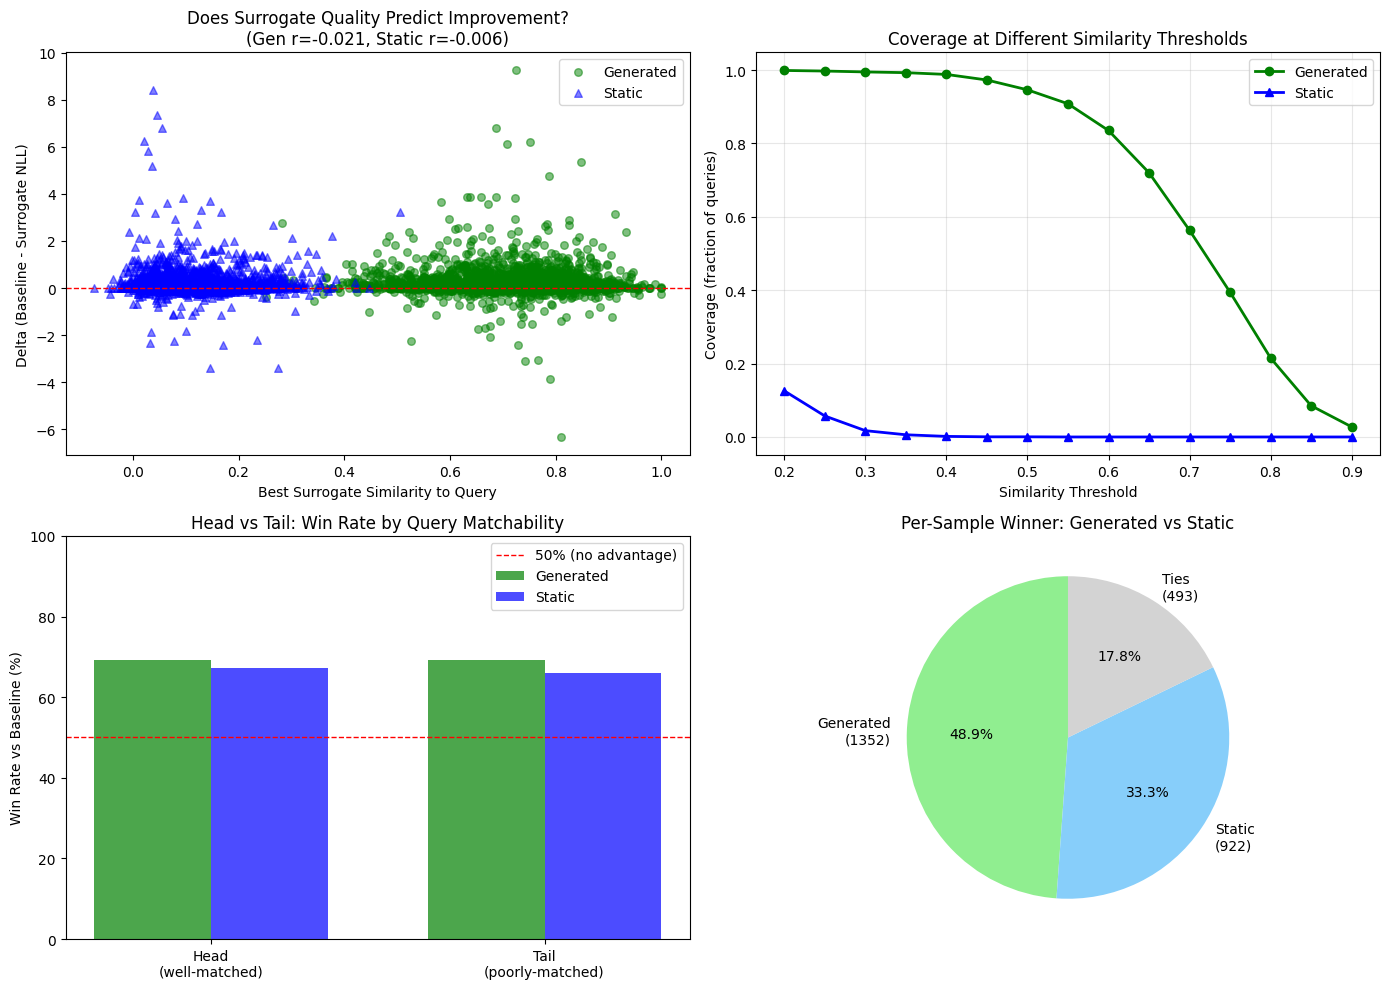


Figure saved to: additional_analysis.png


In [29]:
# Visualization for additional analyses
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Similarity vs Delta scatter (testing correlation)
ax1 = axes[0, 0]
ax1.scatter([r['gen_routed_similarity'] for r in results], 
            [r['delta_gen_routed'] for r in results], 
            alpha=0.5, c='green', label='Generated', s=30)
ax1.scatter([r['static_routed_similarity'] for r in results], 
            [r['delta_static_routed'] for r in results], 
            alpha=0.5, c='blue', label='Static', s=30, marker='^')
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax1.set_xlabel('Best Surrogate Similarity to Query')
ax1.set_ylabel('Delta (Baseline - Surrogate NLL)')
ax1.set_title(f'Does Surrogate Quality Predict Improvement?\n(Gen r={gen_corr:.3f}, Static r={static_corr:.3f})')
ax1.legend()

# Plot 2: Coverage curves
ax2 = axes[0, 1]
thresholds = np.linspace(0.2, 0.9, 15)
gen_coverage = [sum(1 for r in results if r['gen_routed_similarity'] >= t)/len(results) for t in thresholds]
static_coverage = [sum(1 for r in results if r['static_routed_similarity'] >= t)/len(results) for t in thresholds]
ax2.plot(thresholds, gen_coverage, 'g-', linewidth=2, label='Generated', marker='o')
ax2.plot(thresholds, static_coverage, 'b-', linewidth=2, label='Static', marker='^')
ax2.set_xlabel('Similarity Threshold')
ax2.set_ylabel('Coverage (fraction of queries)')
ax2.set_title('Coverage at Different Similarity Thresholds')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Head vs Tail comparison
ax3 = axes[1, 0]
x = np.arange(2)
width = 0.35
gen_rates = [head_analysis['gen_win_rate']*100, tail_analysis['gen_win_rate']*100]
static_rates = [head_analysis['static_win_rate']*100, tail_analysis['static_win_rate']*100]
bars1 = ax3.bar(x - width/2, gen_rates, width, label='Generated', color='green', alpha=0.7)
bars2 = ax3.bar(x + width/2, static_rates, width, label='Static', color='blue', alpha=0.7)
ax3.axhline(y=50, color='red', linestyle='--', linewidth=1, label='50% (no advantage)')
ax3.set_xticks(x)
ax3.set_xticklabels(['Head\n(well-matched)', 'Tail\n(poorly-matched)'])
ax3.set_ylabel('Win Rate vs Baseline (%)')
ax3.set_title('Head vs Tail: Win Rate by Query Matchability')
ax3.legend()
ax3.set_ylim(0, 100)

# Plot 4: Winner breakdown pie chart
ax4 = axes[1, 1]
if len(gen_wins) > 0 and len(static_wins) > 0:
    sizes = [len(gen_wins), len(static_wins), len(ties)]
    labels = [f'Generated\n({len(gen_wins)})', f'Static\n({len(static_wins)})', f'Ties\n({len(ties)})']
    colors = ['lightgreen', 'lightskyblue', 'lightgray']
    ax4.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax4.set_title('Per-Sample Winner: Generated vs Static')
else:
    ax4.text(0.5, 0.5, 'Insufficient data', ha='center', va='center')
    ax4.set_title('Per-Sample Winner')

plt.tight_layout()
plt.savefig('additional_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to: additional_analysis.png")

In [30]:
# Save results
output_data = {
    'config': {
        'model_name': config.model_name,
        'num_samples': config.num_samples,
        'generated_templates': {k: v['name'] for k, v in TOP_5_SURROGATE_TEMPLATES.items()},
        'static_queries': {k: v['query'] for k, v in STATIC_SURROGATE_QUERIES.items()},
    },
    'analysis': {k: v for k, v in analysis.items() 
                 if k not in ['gen_template_stats', 'static_template_stats']},
    'gen_template_stats': analysis['gen_template_stats'],
    'static_template_stats': analysis['static_template_stats'],
    'results': [
        {
            'sample_idx': i,
            'query': r['query'],
            'baseline_nll': r['baseline_nll'],
            'gen_routed_nll': r['gen_routed_nll'],
            'gen_oracle_nll': r['gen_oracle_nll'],
            'gen_routed_key': r['gen_routed_key'],
            'gen_oracle_key': r['gen_oracle_key'],
            'static_routed_nll': r['static_routed_nll'],
            'static_oracle_nll': r['static_oracle_nll'],
            'static_routed_key': r['static_routed_key'],
            'static_oracle_key': r['static_oracle_key'],
            'delta_gen_routed': r['delta_gen_routed'],
            'delta_static_routed': r['delta_static_routed'],
        }
        for i, r in enumerate(results)
    ]
}

with open('production_simulation_results.json', 'w') as f:
    json.dump(output_data, f, indent=2, default=str)

print("Results saved to: production_simulation_results.json")

Results saved to: production_simulation_results.json
